<a href="https://colab.research.google.com/github/semaHbo/ev-enerji-tahmini/blob/main/Model_Training/SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/ev-enerji-tahmini/train1_scaled_cleaned.csv'
val_path = '/content/drive/MyDrive/ev-enerji-tahmini/val1_scaled_cleaned.csv'

train_df = pd.read_csv(train_path, index_col='date', parse_dates=True)
val_df = pd.read_csv(val_path, index_col='date', parse_dates=True)

X_train = train_df.drop(columns=['Enerji_Tuketimi'])
y_train = train_df['Enerji_Tuketimi']

X_val = val_df.drop(columns=['Enerji_Tuketimi'])
y_val = val_df['Enerji_Tuketimi']

# Log dönüşüm
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Sadeleştirme
silinecekler = [
    'HaftaGunu_Adi_Pzt', 'HaftaGunu_Adi_Salı', 'HaftaGunu_Adi_Cuma',
    'Ay_Adi_Ocak', 'is_weekend', 'Rastgele_Degisken_1', 'Rastgele_Degisken_2'
]

X_train_sade = X_train.drop(columns=silinecekler, errors='ignore')
X_val_sade = X_val.drop(columns=silinecekler, errors='ignore')


Mounted at /content/drive


In [ ]:
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1)
svr_model.fit(X_train_sade, y_train_log)

# Tahmin
y_pred_log = svr_model.predict(X_val_sade)
y_pred = np.expm1(y_pred_log)


In [ ]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(" SVR (Log dönüşümlü) Performansı:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


 SVR (Log dönüşümlü) Performansı:
MAE  : 68.8190
MSE  : 14237.9828
RMSE : 119.3230
R²   : -0.4135


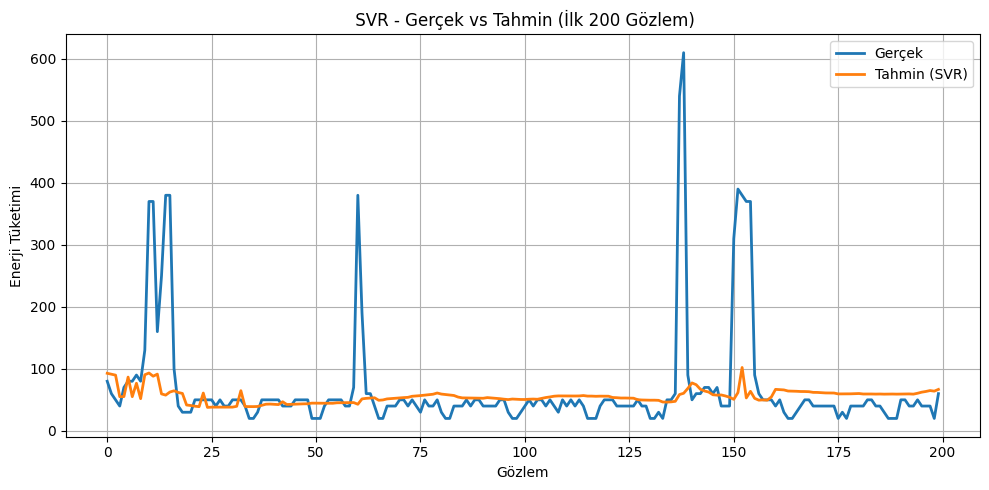

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_val.values[:200], label="Gerçek", linewidth=2)
plt.plot(y_pred[:200], label="Tahmin (SVR)", linewidth=2)
plt.title(" SVR - Gerçek vs Tahmin (İlk 200 Gözlem)")
plt.xlabel("Gözlem")
plt.ylabel("Enerji Tüketimi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

X_train_full = train_df.drop(columns=['Enerji_Tuketimi'])
y_train_full = train_df['Enerji_Tuketimi']

X_val_full = val_df.drop(columns=['Enerji_Tuketimi'])
y_val_full = val_df['Enerji_Tuketimi']


In [ ]:
from sklearn.svm import SVR

svr_model_raw = SVR(kernel='rbf', C=10, epsilon=0.1)
svr_model_raw.fit(X_train_full, y_train_full)

# Tahmin
y_pred_raw = svr_model_raw.predict(X_val_full)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_val_full, y_pred_raw)
mse = mean_squared_error(y_val_full, y_pred_raw)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_full, y_pred_raw)

print("SVR (Orijinal veri) Performansı:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


SVR (Orijinal veri) Performansı:
MAE  : 44.4978
MSE  : 9724.9143
RMSE : 98.6150
R²   : 0.0345


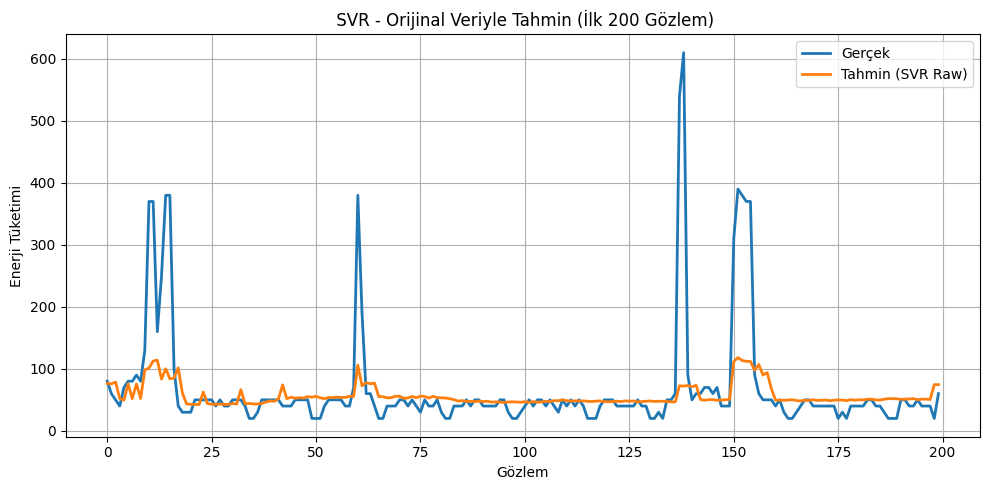

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val_full.values[:200], label="Gerçek", linewidth=2)
plt.plot(y_pred_raw[:200], label="Tahmin (SVR Raw)", linewidth=2)
plt.title(" SVR - Orijinal Veriyle Tahmin (İlk 200 Gözlem)")
plt.xlabel("Gözlem")
plt.ylabel("Enerji Tüketimi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Parametreler
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svr = SVR()

# GridSearchCV
grid_search = GridSearchCV(estimator=svr,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_absolute_error',
                           verbose=2,
                           n_jobs=-1)

#eğitim
grid_search.fit(X_train_full, y_train_full)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear']},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(" En iyi parametreler:", grid_search.best_params_)
print(" En düşük MAE (CV):", -grid_search.best_score_)


 En iyi parametreler: {'C': 1, 'epsilon': 1, 'kernel': 'rbf'}
 En düşük MAE (CV): 46.927548464583055


model en iyi parametrelerle egitilecek

In [ ]:
svr_best = SVR(C=1, epsilon=1, kernel='rbf')
svr_best.fit(X_train_full, y_train_full)

y_pred_best = svr_best.predict(X_val_full)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_val_full, y_pred_best)
mse = mean_squared_error(y_val_full, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_full, y_pred_best)

print("Final SVR Performansı :")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Final SVR Performansı :
MAE  : 43.8766
MSE  : 10129.3086
RMSE : 100.6445
R²   : -0.0056


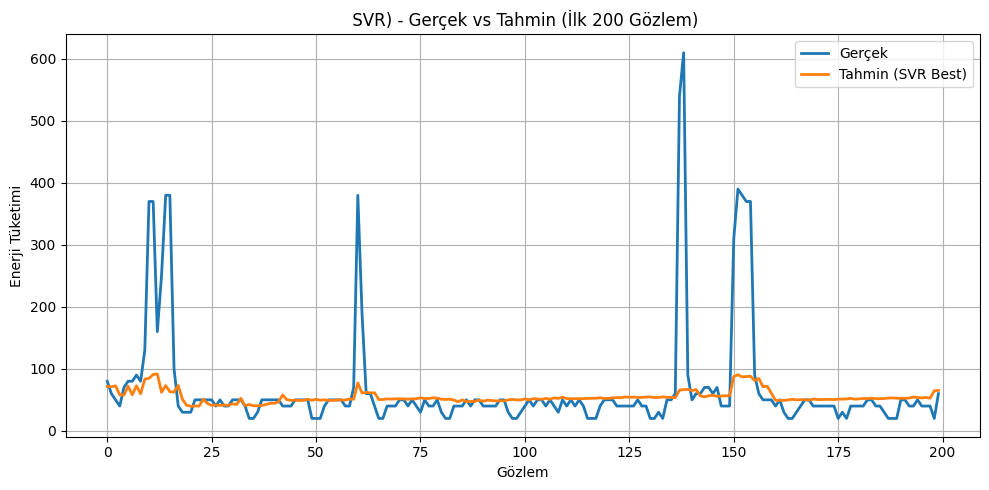

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val_full.values[:200], label="Gerçek", linewidth=2)
plt.plot(y_pred_best[:200], label="Tahmin (SVR Best)", linewidth=2)
plt.title(" SVR) - Gerçek vs Tahmin (İlk 200 Gözlem)")
plt.xlabel("Gözlem")
plt.ylabel("Enerji Tüketimi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()